In [1]:
import prior

dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 12276.11it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

In [2]:
from ai2thor.controller import Controller


house = dataset["train"][3]
controller = Controller(scene=house, snapToGrid=False, rotateStepDegrees=30)
event = controller.step("Pass")
spawn = event.metadata["agent"]["position"]

/home/juyuanli/miniconda3/envs/nav_assistant/lib/python3.11/site-packages/ai2thor/platform.py:154: UserWarning: could not connect to X Display: 5, Can't connect to display ":5": b'Authorization required, but no authorization protocol specified\n'
  warnings.warn(


In [3]:
import numpy as np
def teleport(controller, target=None):
    event = controller.step("GetReachablePositions")
    reachable_positions = event.metadata["actionReturn"]
    # Pick a random target
    if target is None:
        target = np.random.choice(reachable_positions)

    event = controller.step(
        action="TeleportFull",
        x=target["x"],
        y=target["y"],
        z=target["z"],
        rotation={"x": 0, "y": 0, "z": 0},
        horizon=0,
        standing=True
    )

    return event


In [4]:
from rl import PPO, ActorCritic, Env, RolloutBuffer, ClipEnvNoPenalty, CLIPNovelty
from models import LSTMActor, LSTMCritic, FrozenResNetEncoder, SlidingWindowTransformerActor, SlidingWindowTransformerCritic
from cons import MINIBATCHES, EPISODE_STEPS, FEAT_DIM, NUM_ACTIONS, DEVICE

In [5]:
import torch
import matplotlib.pyplot as plt
from rl import save_actor_critic

def train(controller, name: str, ppo: PPO, env: Env, actor_critic: ActorCritic, total_updates=10):
    event = controller.step("Pass")  # prime
    rewards = []
    episode_rewards = []
    for upd in range(total_updates):
        buf = RolloutBuffer()
        for mb in range(MINIBATCHES):
            # collect episodes
            episode_seq = []
            episode_reward = 0
            actions_seq = []
            for t in range(1, EPISODE_STEPS + 1):
                with torch.no_grad():
                    obs_t = ppo.obs_from_event(event)  # (C,H,W)
                    obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
                    obs_seq = torch.stack(episode_seq + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

                if len(actions_seq) == 0:
                    actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
                
                actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
                logits, value = ppo.act_and_value(obs_seq, actions_tensor, actor_critic)
                dist = torch.distributions.Categorical(logits=logits)
                action_idx = dist.sample()
                logp = dist.log_prob(action_idx)
                
                action_idx, logp = action_idx.item(), logp.item()
                event, reward = env.step_env(controller, action_idx)
                done = t == EPISODE_STEPS

                # store one step
                buf.add(obs_t_encoded, action_idx, logp, reward, value, done)
                episode_seq.append(obs_t_encoded)
                rewards.append(reward)
                actions_seq.append(action_idx)
                
                episode_reward += reward / EPISODE_STEPS

                # 50% chance of teleport
                if done:
                    env.reset()
                    if np.random.rand() > 0.5:
                        event = teleport(controller)
            episode_rewards.append(episode_reward)
                
        ppo.ppo_update(buf, actor_critic)
        save_actor_critic(actor_critic, name)
        
        print(f"Update {upd+1}/{total_updates} — steps: {len(buf)}")
        plt.plot(rewards)
        plt.show()
        plt.plot(episode_rewards)
        plt.show()
    return buf, rewards

In [6]:
ENTROPY_COEF = 0.08

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnvNoPenalty(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)


[PPO] Epoch 0: Loss=69.6578, Policy=0.0052, Value=139.4755
[PPO] Epoch 10: Loss=52.7563, Policy=0.0307, Value=105.6232
[PPO] Epoch 20: Loss=44.7164, Policy=0.0054, Value=89.5946
[PPO] Epoch 30: Loss=36.2712, Policy=-0.0079, Value=72.7306
Approx KL Learned: 0.017134234309196472
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 1/10 — steps: 4096


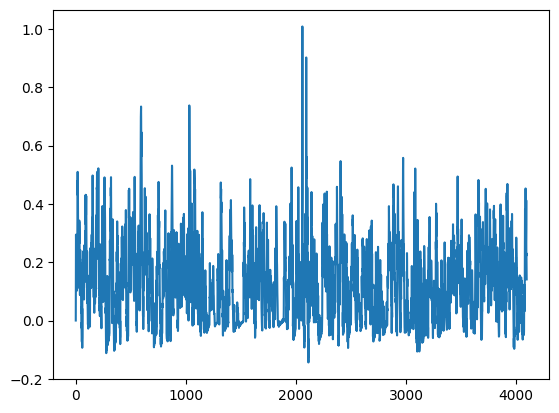

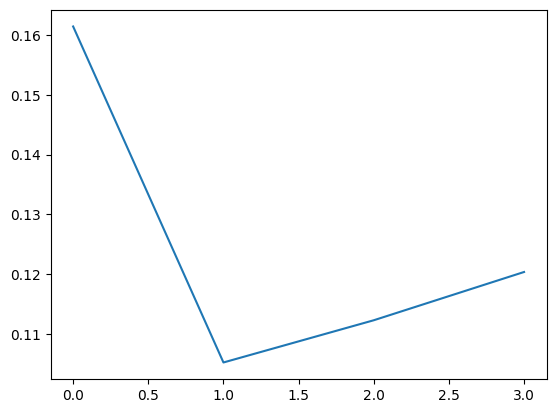

[PPO] Epoch 0: Loss=79.2974, Policy=0.0010, Value=158.7650
[PPO] Epoch 10: Loss=62.2108, Policy=0.0009, Value=124.5913
[PPO] Epoch 20: Loss=55.2326, Policy=-0.0028, Value=110.6438
[PPO] Epoch 30: Loss=52.7264, Policy=-0.0064, Value=105.6385
Approx KL Learned: 0.008175574243068695
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 2/10 — steps: 4096


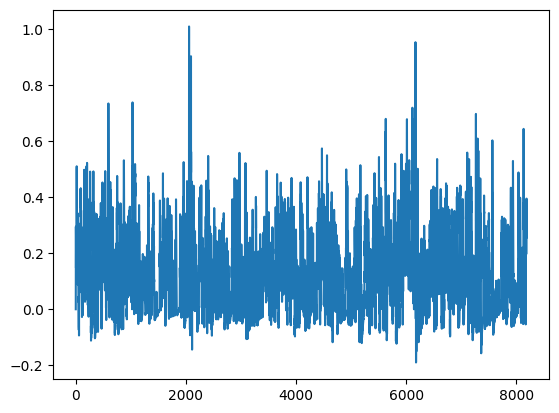

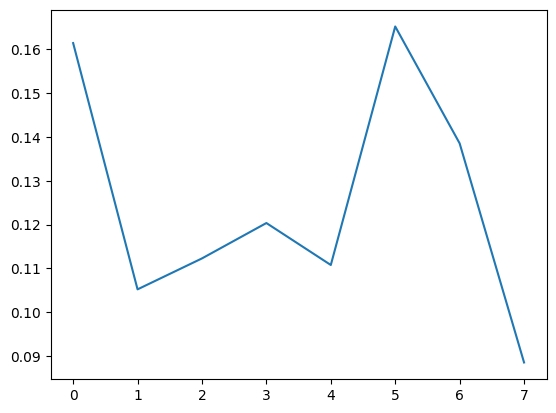

[PPO] Epoch 0: Loss=71.7834, Policy=0.0006, Value=143.7387
[PPO] Epoch 10: Loss=58.1222, Policy=-0.0030, Value=116.4229
[PPO] Epoch 20: Loss=48.4912, Policy=-0.0106, Value=97.1762
[PPO] Epoch 30: Loss=42.7639, Policy=-0.0126, Value=85.7253
Approx KL Learned: 0.013944759964942932
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 3/10 — steps: 4096


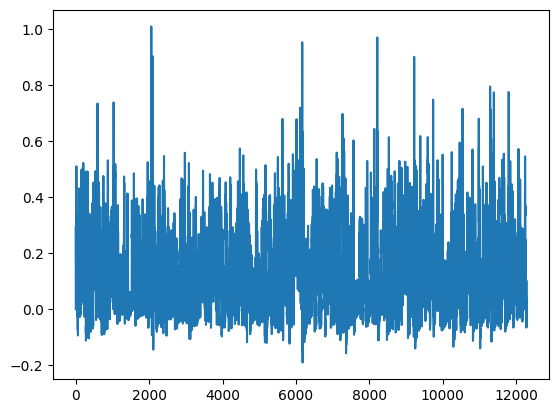

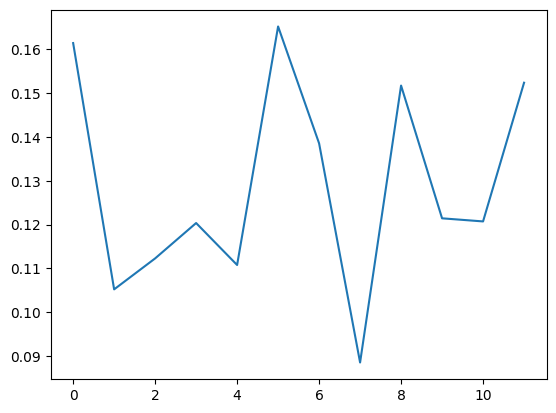

[PPO] Epoch 0: Loss=86.8893, Policy=-0.0010, Value=173.9533
[PPO] Epoch 10: Loss=63.8386, Policy=-0.0019, Value=127.8529
[PPO] Epoch 20: Loss=56.2593, Policy=-0.0114, Value=112.7108
[PPO] Epoch 30: Loss=51.8710, Policy=-0.0114, Value=103.9360
Approx KL Learned: 0.015358345583081245
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 4/10 — steps: 4096


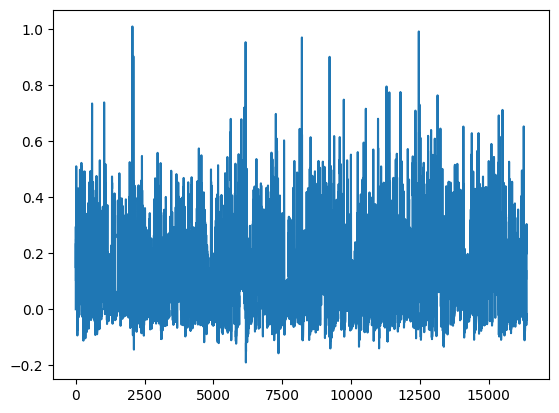

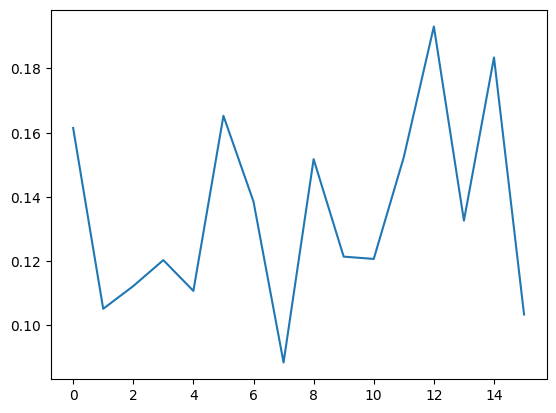

[PPO] Epoch 0: Loss=66.0782, Policy=-0.0008, Value=132.3271
[PPO] Epoch 10: Loss=52.3532, Policy=-0.0072, Value=104.8888
[PPO] Epoch 20: Loss=43.7028, Policy=-0.0135, Value=87.5983
[PPO] Epoch 30: Loss=38.2791, Policy=-0.0190, Value=76.7628
Approx KL Learned: 0.017995495349168777
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 5/10 — steps: 4096


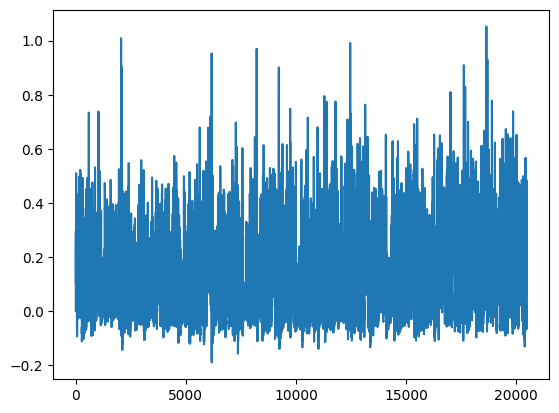

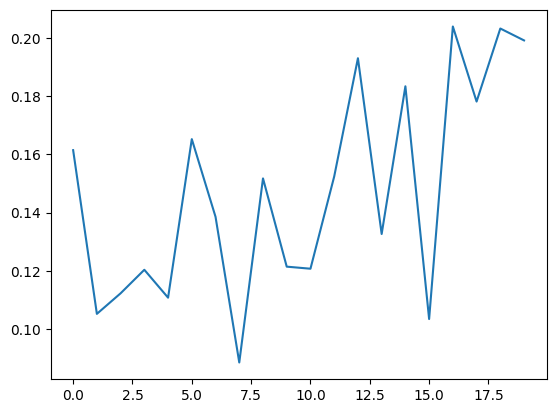

[PPO] Epoch 0: Loss=57.2483, Policy=0.0034, Value=114.6437
[PPO] Epoch 10: Loss=45.5291, Policy=-0.0079, Value=91.2343
[PPO] Epoch 20: Loss=41.2106, Policy=-0.0033, Value=82.5925
[PPO] Epoch 30: Loss=38.4578, Policy=0.0044, Value=77.0697
Approx KL Learned: 0.015477359294891357
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 6/10 — steps: 4096


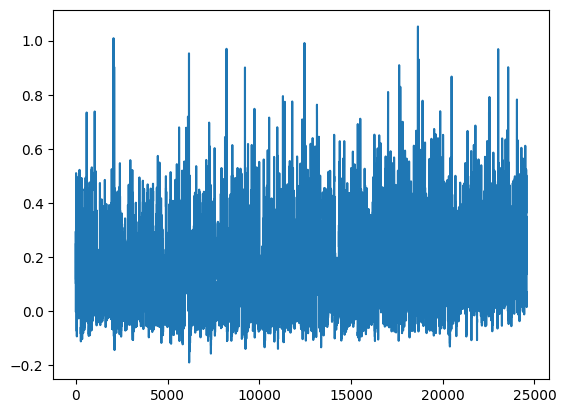

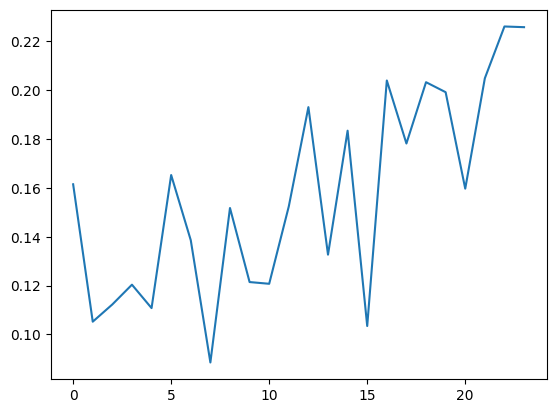

[PPO] Epoch 0: Loss=68.6613, Policy=0.0030, Value=137.4693
[PPO] Epoch 10: Loss=53.2060, Policy=-0.0083, Value=106.5828
[PPO] Epoch 20: Loss=45.2725, Policy=-0.0095, Value=90.7188
[PPO] Epoch 30: Loss=46.3327, Policy=-0.0129, Value=92.8477
Approx KL Learned: 0.032375406473875046
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 7/10 — steps: 4096


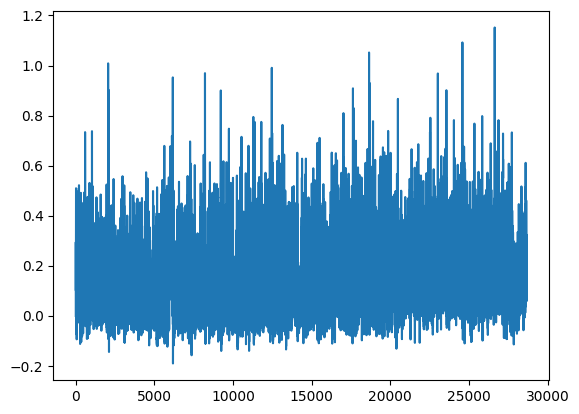

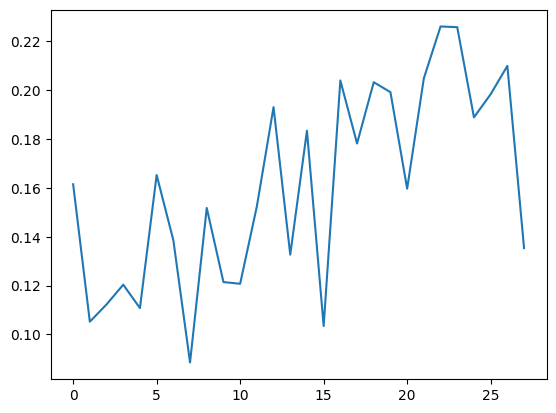

[PPO] Epoch 0: Loss=60.1952, Policy=-0.0015, Value=120.5518
[PPO] Epoch 10: Loss=51.3107, Policy=-0.0037, Value=102.7857
[PPO] Epoch 20: Loss=45.6805, Policy=-0.0087, Value=91.5364
[PPO] Epoch 30: Loss=40.9196, Policy=-0.0121, Value=82.0200
Approx KL Learned: 0.01162060908973217
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 8/10 — steps: 4096


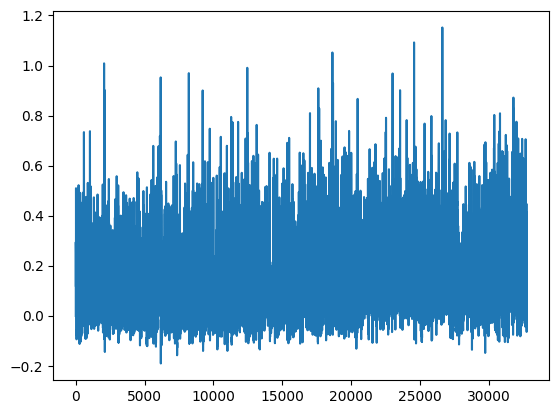

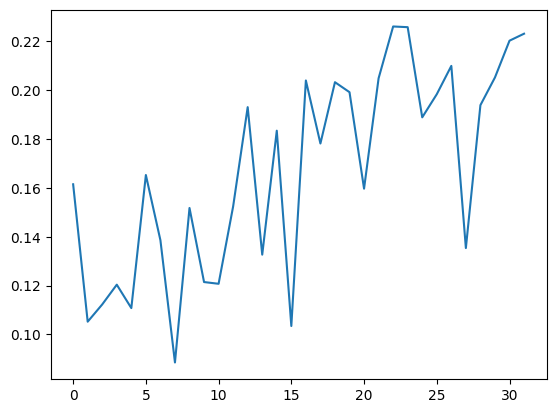

[PPO] Epoch 0: Loss=62.5916, Policy=0.0009, Value=125.3379
[PPO] Epoch 10: Loss=49.3266, Policy=-0.0058, Value=98.8166
[PPO] Epoch 20: Loss=39.4553, Policy=-0.0061, Value=79.0774
[PPO] Epoch 30: Loss=38.0843, Policy=-0.0136, Value=76.3482
Approx KL Learned: 0.00881922710686922
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 9/10 — steps: 4096


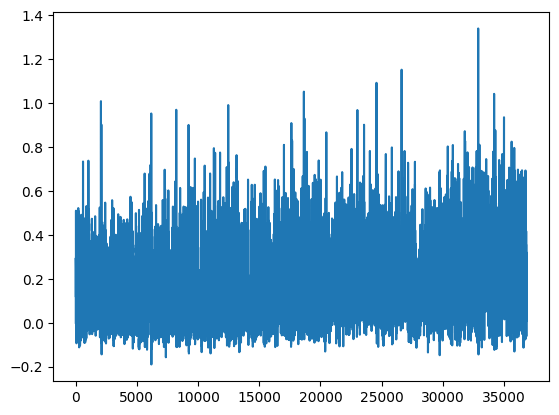

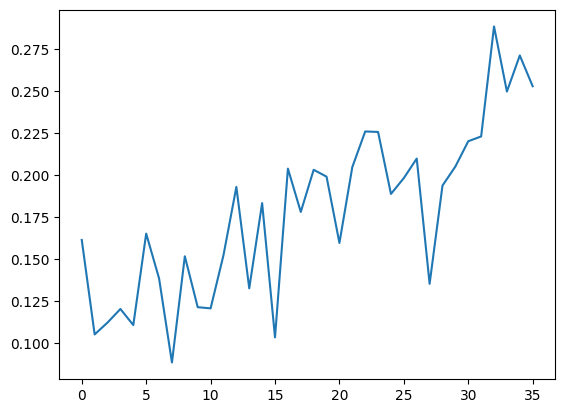

[PPO] Epoch 0: Loss=76.9255, Policy=0.0018, Value=154.0019
[PPO] Epoch 10: Loss=57.6856, Policy=-0.0025, Value=115.5287
[PPO] Epoch 20: Loss=45.5575, Policy=-0.0088, Value=91.2841
[PPO] Epoch 30: Loss=37.0627, Policy=-0.0126, Value=74.3016
Approx KL Learned: 0.012530812062323093
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10.pt
Update 10/10 — steps: 4096


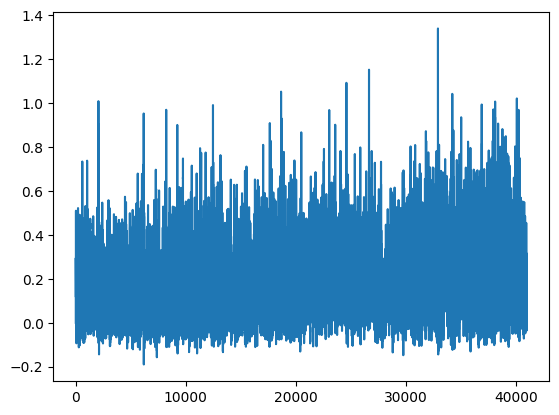

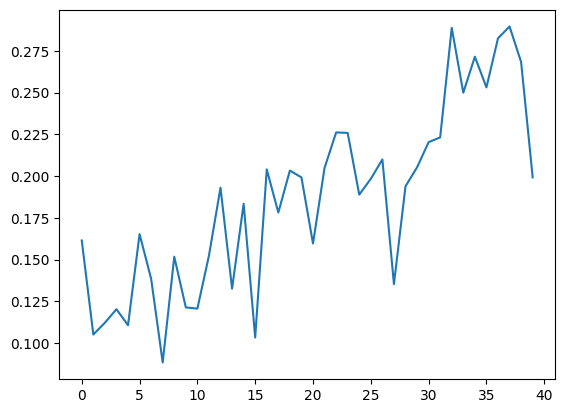

In [7]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training_10.pt", ppo, clip_env, clip_actor_critic, 10)

[PPO] Epoch 0: Loss=73.7780, Policy=0.0049, Value=147.7008
[PPO] Epoch 10: Loss=56.0776, Policy=-0.0042, Value=112.3129
[PPO] Epoch 20: Loss=43.6155, Policy=-0.0137, Value=87.4081
[PPO] Epoch 30: Loss=35.2037, Policy=-0.0219, Value=70.5998
Approx KL Learned: 0.021372223272919655
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 1/10 — steps: 4096


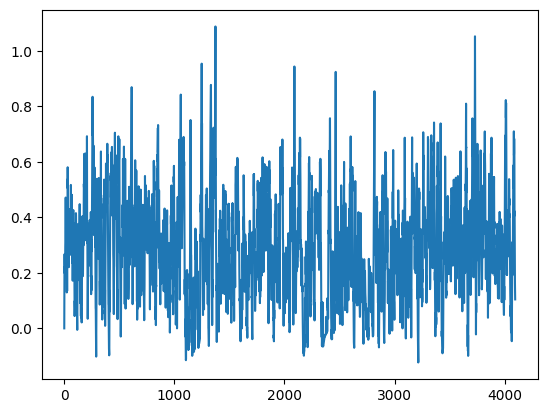

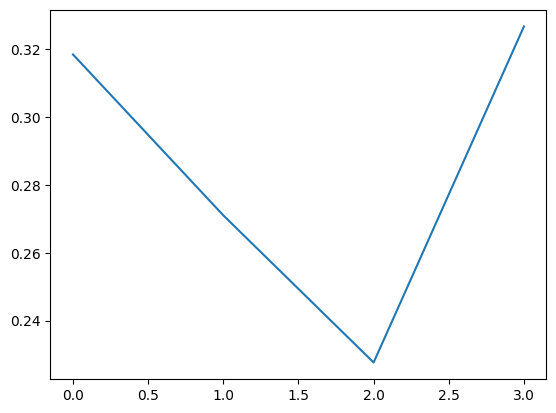

[PPO] Epoch 0: Loss=88.1762, Policy=0.0038, Value=176.4890
[PPO] Epoch 10: Loss=72.7396, Policy=0.0012, Value=145.6192
[PPO] Epoch 20: Loss=64.6741, Policy=-0.0115, Value=129.5154
[PPO] Epoch 30: Loss=59.7738, Policy=-0.0180, Value=119.7266
Approx KL Learned: 0.028398167341947556
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 2/10 — steps: 4096


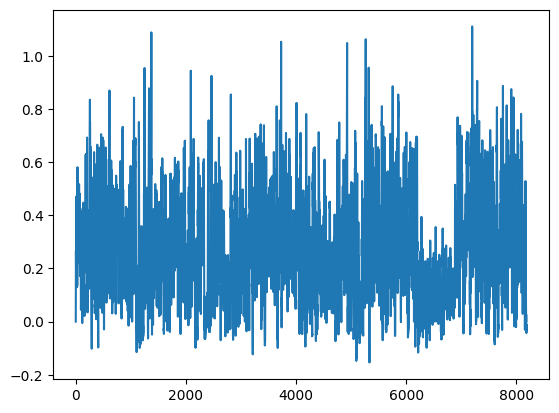

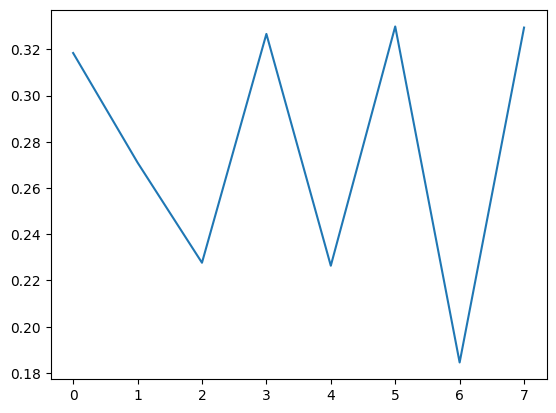

[PPO] Epoch 0: Loss=72.3994, Policy=0.0025, Value=144.9380
[PPO] Epoch 10: Loss=60.9787, Policy=0.0033, Value=122.0936
[PPO] Epoch 20: Loss=54.6373, Policy=-0.0046, Value=109.4236
[PPO] Epoch 30: Loss=47.6300, Policy=-0.0137, Value=95.4283
Approx KL Learned: 0.019529350101947784
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 3/10 — steps: 4096


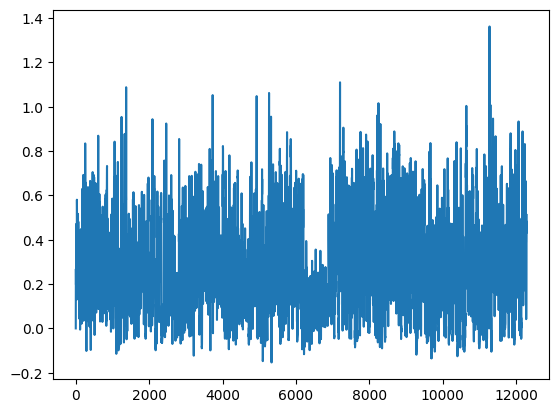

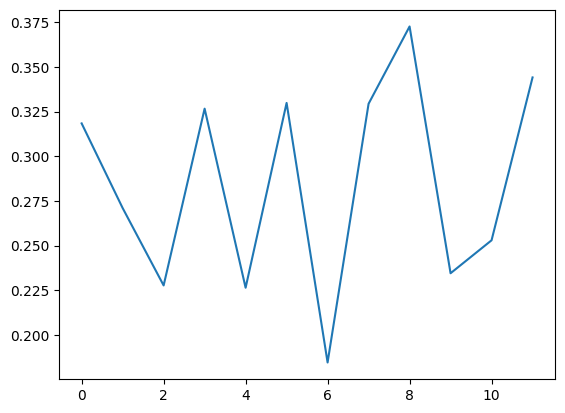

[PPO] Epoch 0: Loss=70.4174, Policy=0.0026, Value=140.9597
[PPO] Epoch 10: Loss=54.6077, Policy=-0.0025, Value=109.3529
[PPO] Epoch 20: Loss=42.0193, Policy=-0.0156, Value=84.1980
[PPO] Epoch 30: Loss=36.3314, Policy=-0.0279, Value=72.8439
Approx KL Learned: 0.05092991143465042
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 4/10 — steps: 4096


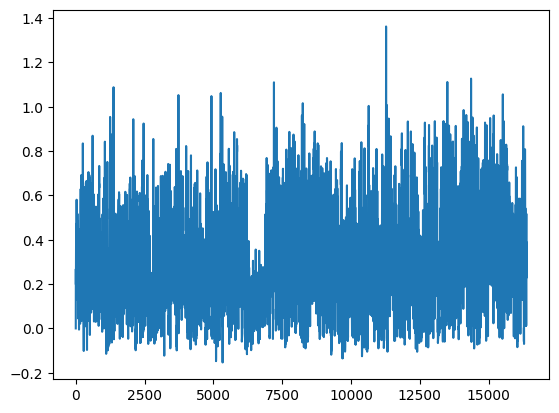

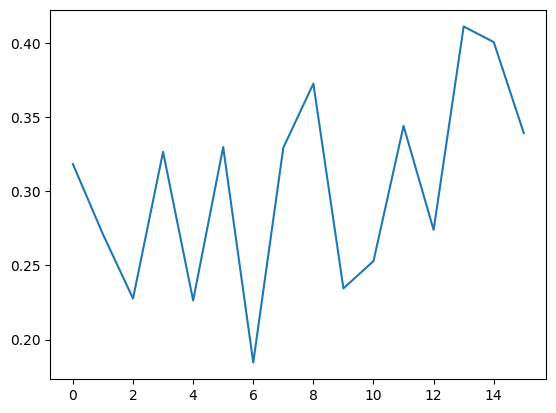

[PPO] Epoch 0: Loss=57.8726, Policy=0.0057, Value=115.8636
[PPO] Epoch 10: Loss=49.0044, Policy=0.0092, Value=98.1061
[PPO] Epoch 20: Loss=44.1659, Policy=0.0070, Value=88.4555
[PPO] Epoch 30: Loss=39.3706, Policy=-0.0063, Value=78.8865
Approx KL Learned: 0.02088724821805954
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 5/10 — steps: 4096


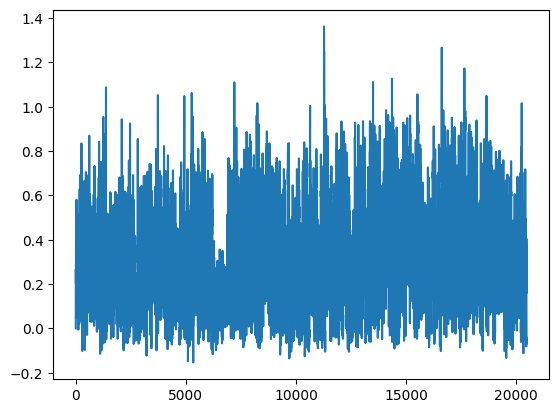

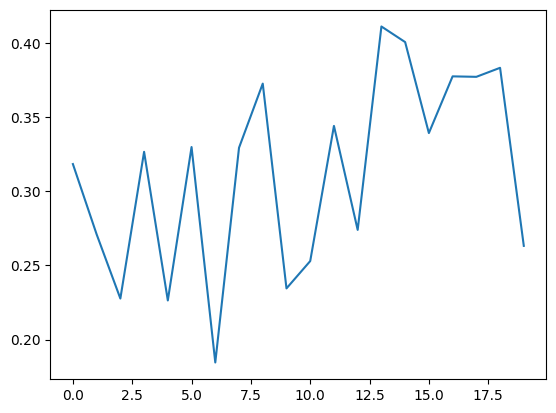

[PPO] Epoch 0: Loss=72.7989, Policy=0.0019, Value=145.7218
[PPO] Epoch 10: Loss=55.5220, Policy=-0.0067, Value=111.1828
[PPO] Epoch 20: Loss=45.3216, Policy=-0.0183, Value=90.8024
[PPO] Epoch 30: Loss=39.4190, Policy=-0.0253, Value=79.0152
Approx KL Learned: 0.021939950063824654
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 6/10 — steps: 4096


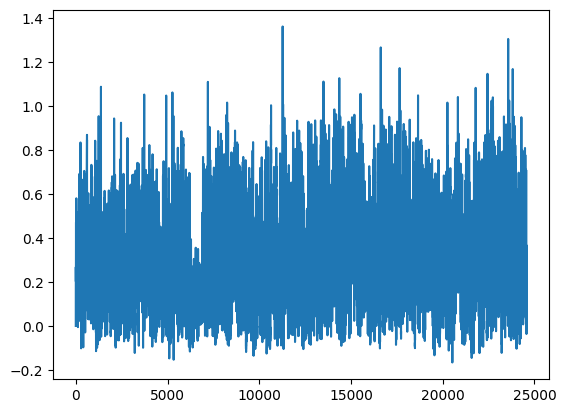

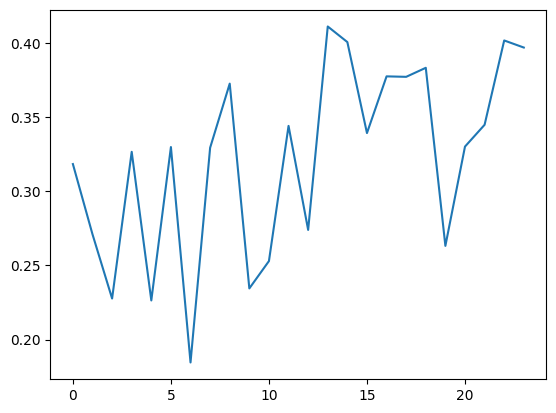

[PPO] Epoch 0: Loss=71.3870, Policy=0.0033, Value=142.8887
[PPO] Epoch 10: Loss=57.2473, Policy=-0.0027, Value=114.6225
[PPO] Epoch 20: Loss=52.7954, Policy=-0.0077, Value=105.7292
[PPO] Epoch 30: Loss=39.2291, Policy=-0.0171, Value=78.6142
Approx KL Learned: 0.018561333417892456
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 7/10 — steps: 4096


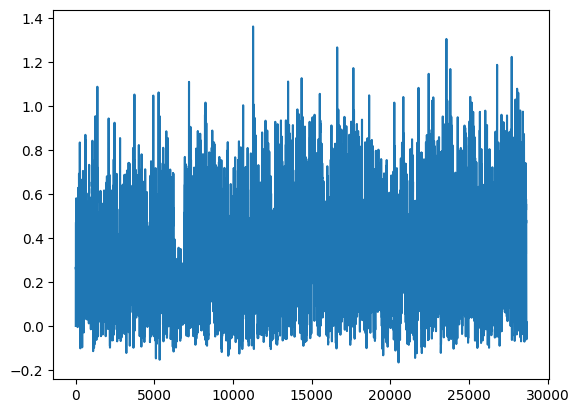

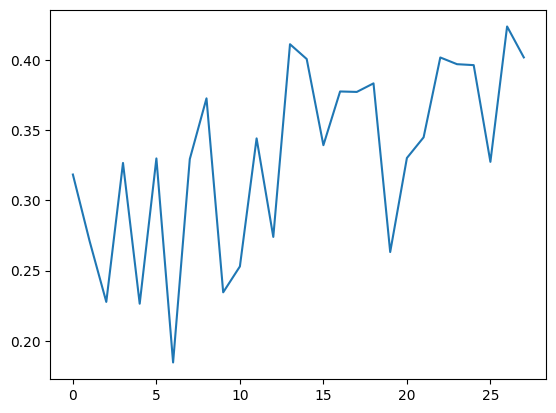

[PPO] Epoch 0: Loss=72.2097, Policy=0.0052, Value=144.5375
[PPO] Epoch 10: Loss=54.5056, Policy=-0.0025, Value=109.1422
[PPO] Epoch 20: Loss=40.2534, Policy=-0.0120, Value=80.6499
[PPO] Epoch 30: Loss=32.4500, Policy=-0.0127, Value=65.0451
Approx KL Learned: 0.3716450333595276
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 8/10 — steps: 4096


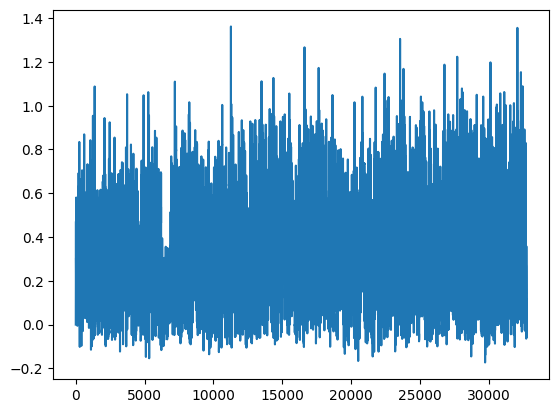

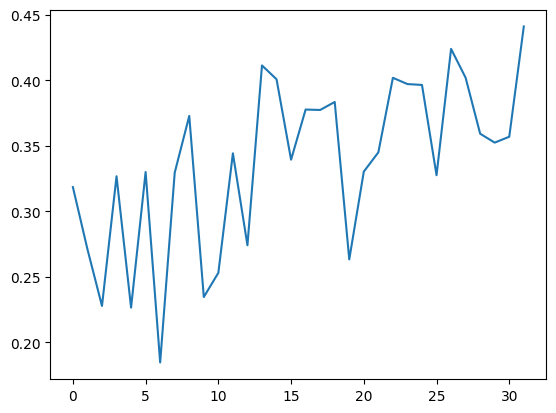

[PPO] Epoch 0: Loss=67.8181, Policy=0.0044, Value=135.7430
[PPO] Epoch 10: Loss=41.2768, Policy=-0.0057, Value=82.6977
[PPO] Epoch 20: Loss=34.7478, Policy=-0.0125, Value=69.6542
[PPO] Epoch 30: Loss=29.5487, Policy=-0.0206, Value=59.2691
Approx KL Learned: 0.054103583097457886
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 9/10 — steps: 4096


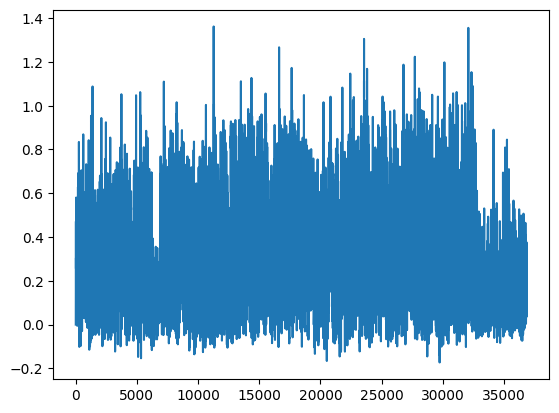

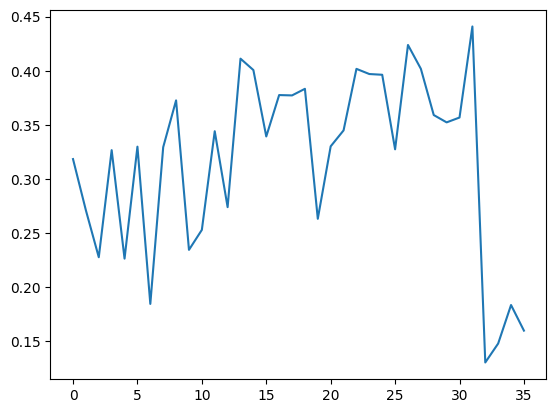

[PPO] Epoch 0: Loss=55.6007, Policy=0.0036, Value=111.3302
[PPO] Epoch 10: Loss=37.7587, Policy=-0.0173, Value=75.6944
[PPO] Epoch 20: Loss=27.0997, Policy=-0.0184, Value=54.3768
[PPO] Epoch 30: Loss=22.5689, Policy=0.1329, Value=44.9925
Approx KL Learned: 0.04543589800596237
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20.pt
Update 10/10 — steps: 4096


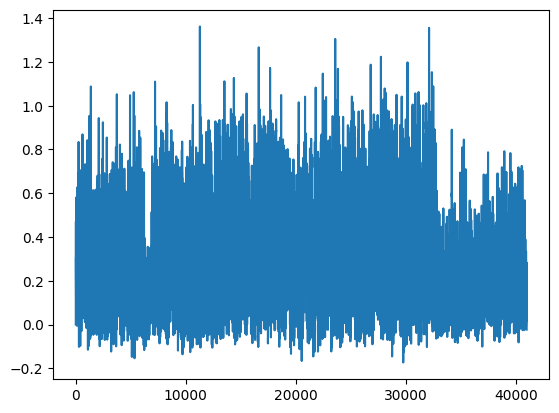

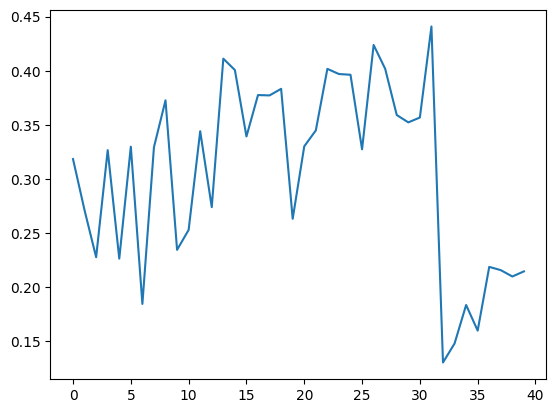

In [8]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training_20.pt", ppo, clip_env, clip_actor_critic, 10)

In [9]:
ENTROPY_COEF = 0.05

ppo = PPO(ENTROPY_COEF)
encoder = FrozenResNetEncoder()
actor = SlidingWindowTransformerActor(FEAT_DIM, NUM_ACTIONS)
critic = SlidingWindowTransformerCritic(FEAT_DIM)
clip_novelty = CLIPNovelty()
clip_env = ClipEnvNoPenalty(clip_novelty)
clip_actor_critic = ActorCritic(encoder, actor, critic)

[PPO] Epoch 0: Loss=75.7034, Policy=0.0056, Value=151.5012
[PPO] Epoch 10: Loss=56.6435, Policy=0.0210, Value=113.3461
[PPO] Epoch 20: Loss=48.1359, Policy=-0.0017, Value=96.3804
[PPO] Epoch 30: Loss=42.7569, Policy=-0.0023, Value=85.6246
Approx KL Learned: 0.023882746696472168
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 1/10 — steps: 4096


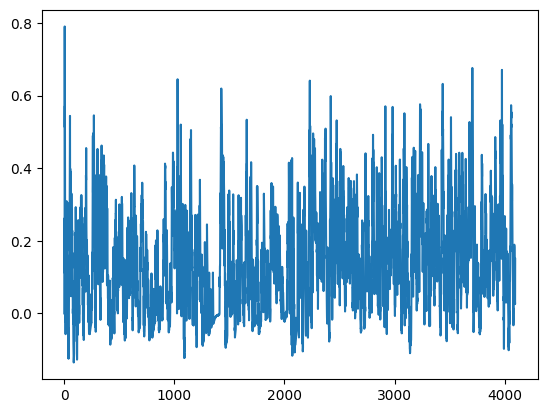

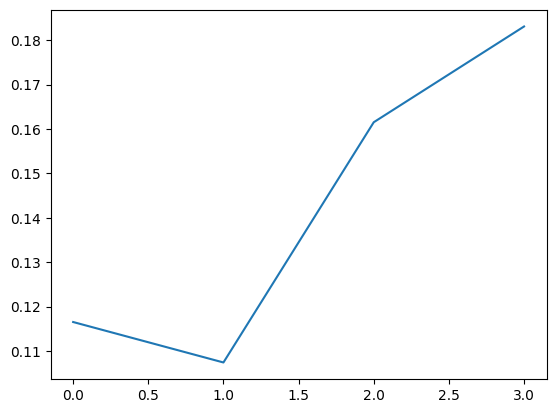

[PPO] Epoch 0: Loss=68.3751, Policy=0.0047, Value=136.8457
[PPO] Epoch 10: Loss=62.5920, Policy=0.0035, Value=125.2834
[PPO] Epoch 20: Loss=55.4404, Policy=-0.0040, Value=110.9909
[PPO] Epoch 30: Loss=49.6012, Policy=-0.0039, Value=99.3136
Approx KL Learned: 0.012105230242013931
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 2/10 — steps: 4096


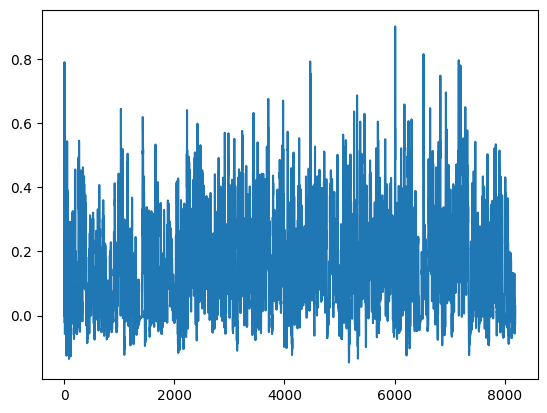

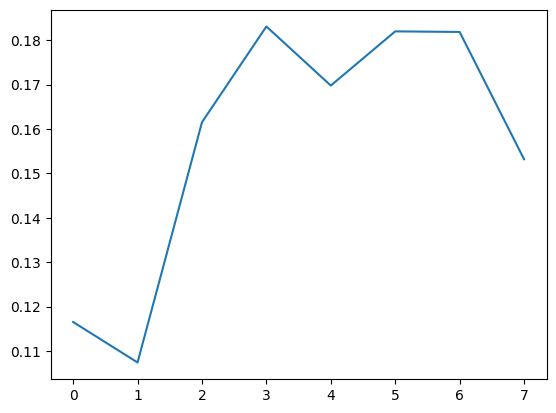

[PPO] Epoch 0: Loss=72.1583, Policy=0.0007, Value=144.4203
[PPO] Epoch 10: Loss=64.8672, Policy=-0.0066, Value=129.8513
[PPO] Epoch 20: Loss=58.4077, Policy=-0.0100, Value=116.9383
[PPO] Epoch 30: Loss=55.0936, Policy=-0.0117, Value=110.3143
Approx KL Learned: 0.009118666872382164
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 3/10 — steps: 4096


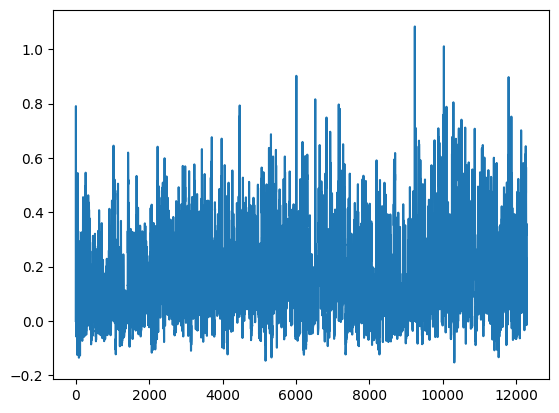

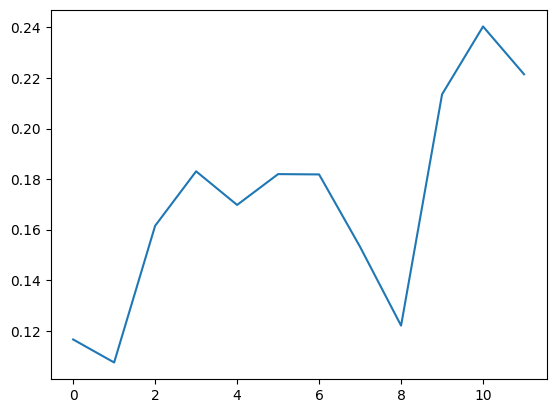

[PPO] Epoch 0: Loss=63.0580, Policy=0.0013, Value=126.2156
[PPO] Epoch 10: Loss=57.3517, Policy=0.0002, Value=114.8049
[PPO] Epoch 20: Loss=52.6236, Policy=-0.0059, Value=105.3592
[PPO] Epoch 30: Loss=44.3274, Policy=-0.0067, Value=88.7695
Approx KL Learned: 0.019534848630428314
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 4/10 — steps: 4096


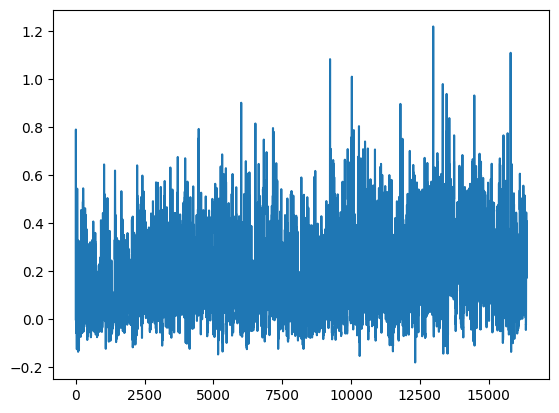

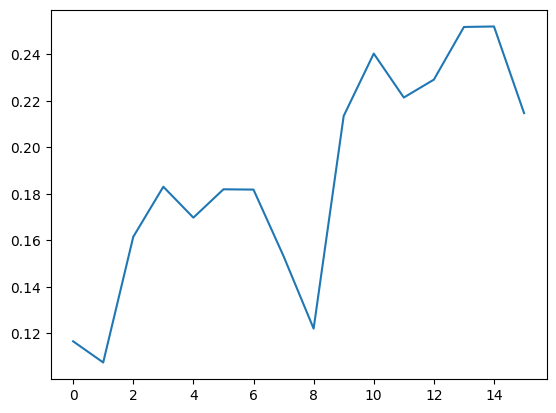

[PPO] Epoch 0: Loss=67.8208, Policy=0.0019, Value=135.7380
[PPO] Epoch 10: Loss=54.8685, Policy=0.0020, Value=109.8317
[PPO] Epoch 20: Loss=46.2847, Policy=-0.0069, Value=92.6832
[PPO] Epoch 30: Loss=41.3742, Policy=-0.0052, Value=82.8595
Approx KL Learned: 0.009149008430540562
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 5/10 — steps: 4096


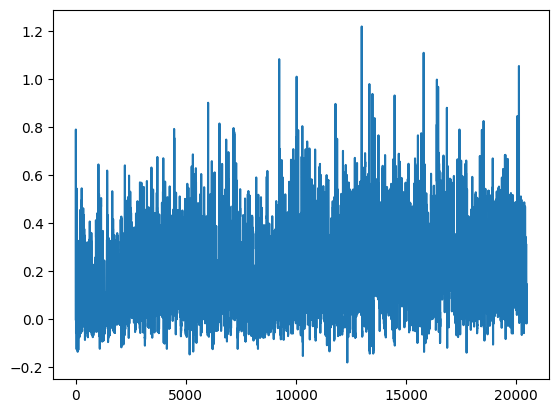

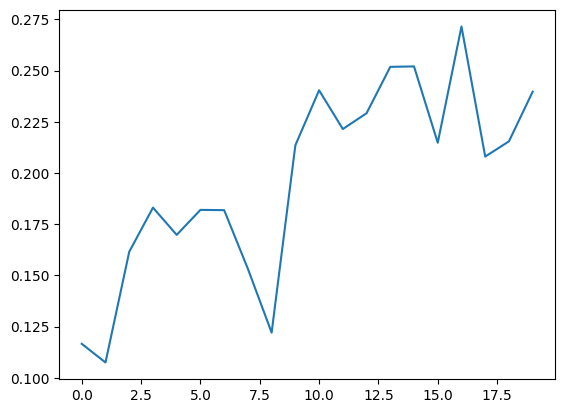

[PPO] Epoch 0: Loss=66.4906, Policy=0.0032, Value=133.0747
[PPO] Epoch 10: Loss=60.8290, Policy=0.0007, Value=121.7544
[PPO] Epoch 20: Loss=53.5782, Policy=-0.0052, Value=107.2656
[PPO] Epoch 30: Loss=51.1994, Policy=-0.0012, Value=102.4987
Approx KL Learned: 0.01684108003973961
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 6/10 — steps: 4096


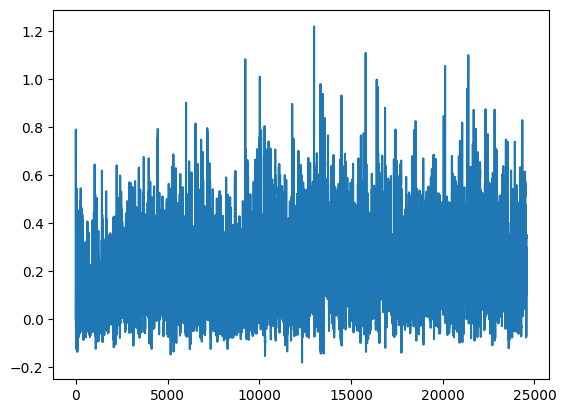

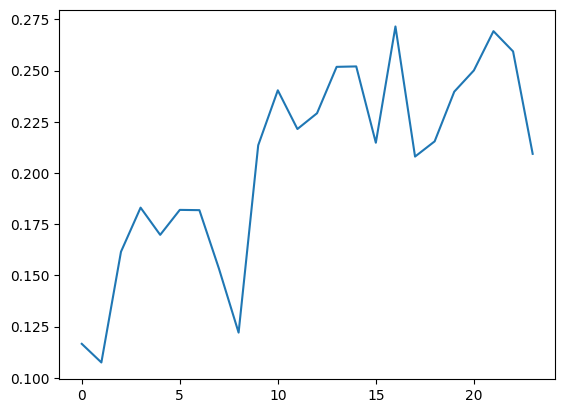

[PPO] Epoch 0: Loss=73.6298, Policy=0.0036, Value=147.3509
[PPO] Epoch 10: Loss=53.9016, Policy=0.0012, Value=107.8979
[PPO] Epoch 20: Loss=48.9922, Policy=-0.0013, Value=98.0840
[PPO] Epoch 30: Loss=45.4917, Policy=-0.0069, Value=91.0942
Approx KL Learned: 0.017131611704826355
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 7/10 — steps: 4096


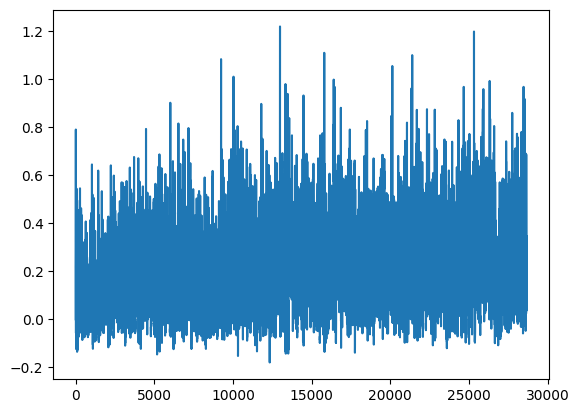

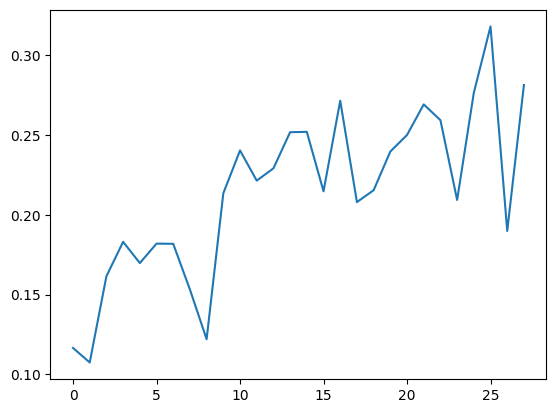

[PPO] Epoch 0: Loss=76.8858, Policy=0.0001, Value=153.8682
[PPO] Epoch 10: Loss=61.4272, Policy=-0.0048, Value=122.9561
[PPO] Epoch 20: Loss=51.8949, Policy=-0.0042, Value=103.8942
[PPO] Epoch 30: Loss=52.6410, Policy=-0.0100, Value=105.3957
Approx KL Learned: 0.011356109753251076
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 8/10 — steps: 4096


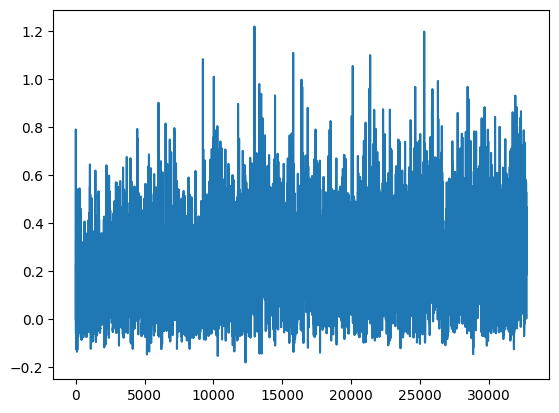

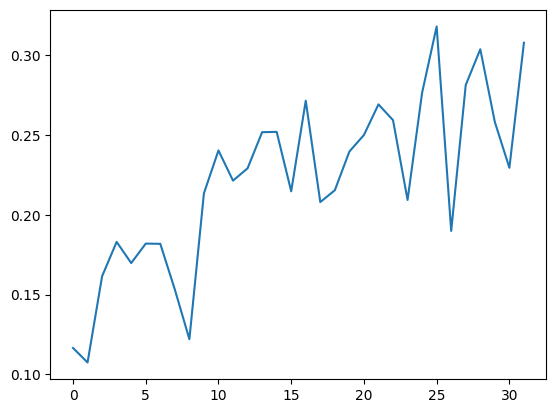

[PPO] Epoch 0: Loss=65.7175, Policy=-0.0012, Value=131.5311
[PPO] Epoch 10: Loss=59.6130, Policy=-0.0051, Value=119.3268
[PPO] Epoch 20: Loss=54.1764, Policy=-0.0092, Value=108.4624
[PPO] Epoch 30: Loss=49.6926, Policy=-0.0177, Value=99.5112
Approx KL Learned: 0.01592782512307167
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 9/10 — steps: 4096


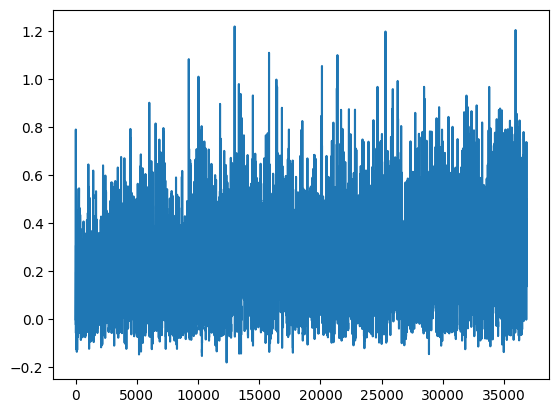

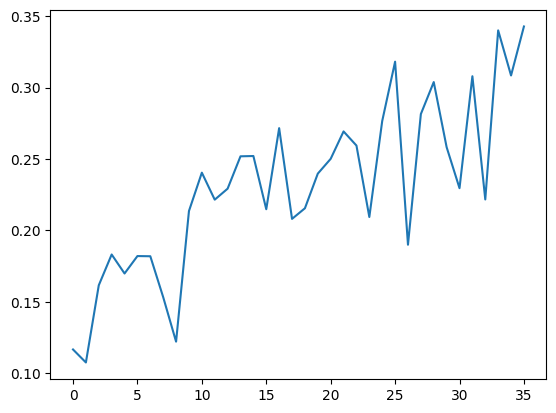

[PPO] Epoch 0: Loss=82.2228, Policy=0.0022, Value=164.5301
[PPO] Epoch 10: Loss=68.8447, Policy=-0.0048, Value=137.7836
[PPO] Epoch 20: Loss=56.8864, Policy=-0.0078, Value=113.8750
[PPO] Epoch 30: Loss=50.6819, Policy=0.0828, Value=101.2631
Approx KL Learned: 0.06472672522068024
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_10_low_ent.pt
Update 10/10 — steps: 4096


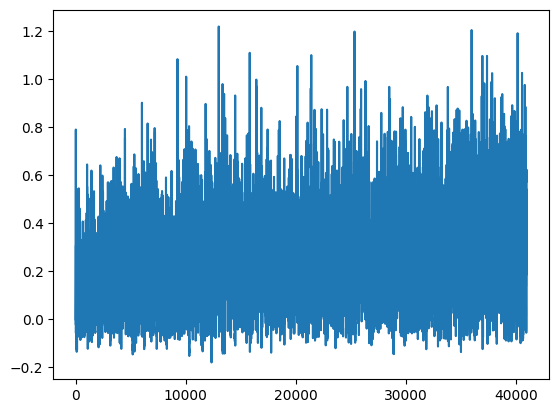

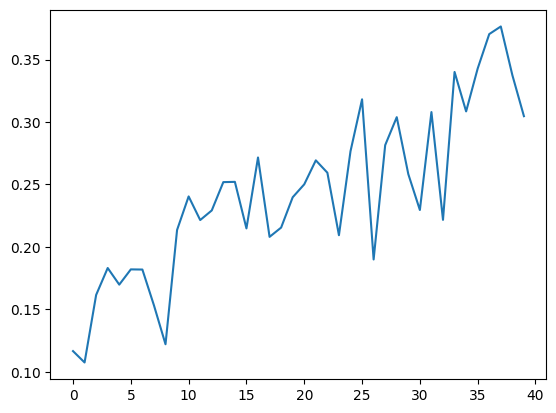

In [10]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training_10_low_ent.pt", ppo, clip_env, clip_actor_critic, 10)

[PPO] Epoch 0: Loss=89.1158, Policy=0.0010, Value=178.3261
[PPO] Epoch 10: Loss=68.3905, Policy=-0.0005, Value=136.8744
[PPO] Epoch 20: Loss=65.7214, Policy=-0.0020, Value=131.5419
[PPO] Epoch 30: Loss=53.5456, Policy=-0.0025, Value=107.1872
Approx KL Learned: 0.020203109830617905
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 1/10 — steps: 4096


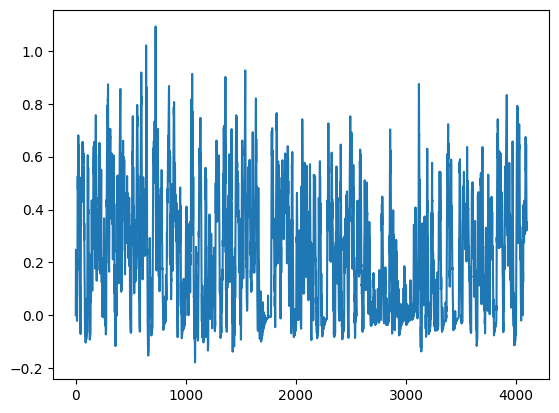

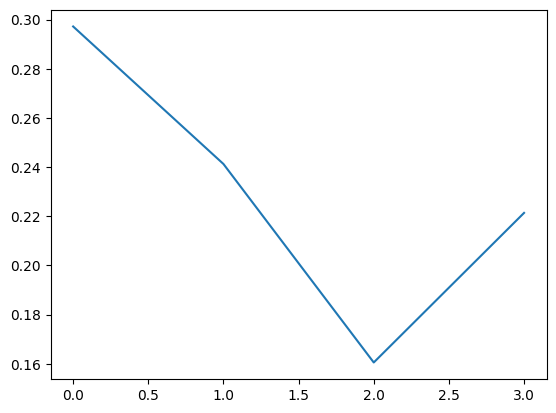

[PPO] Epoch 0: Loss=81.4622, Policy=0.0006, Value=163.0198
[PPO] Epoch 10: Loss=57.9570, Policy=-0.0021, Value=116.0126
[PPO] Epoch 20: Loss=46.9210, Policy=-0.0032, Value=93.9430
[PPO] Epoch 30: Loss=40.6242, Policy=-0.0067, Value=81.3571
Approx KL Learned: 0.00997135415673256
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 2/10 — steps: 4096


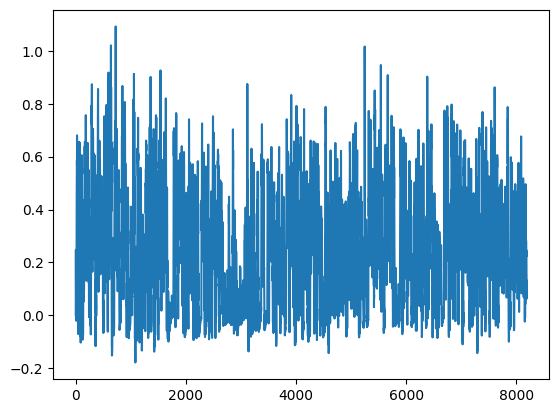

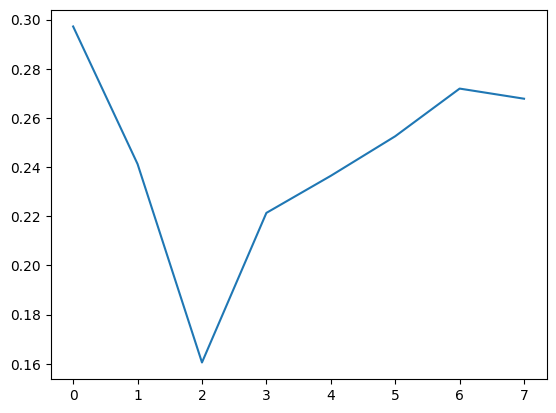

[PPO] Epoch 0: Loss=66.9556, Policy=0.0010, Value=134.0031
[PPO] Epoch 10: Loss=45.0485, Policy=-0.0046, Value=90.1980
[PPO] Epoch 20: Loss=39.4369, Policy=-0.0090, Value=78.9830
[PPO] Epoch 30: Loss=36.1300, Policy=-0.0092, Value=72.3701
Approx KL Learned: 0.011399445123970509
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 3/10 — steps: 4096


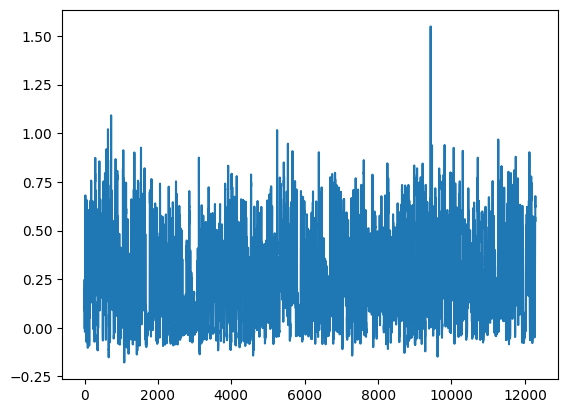

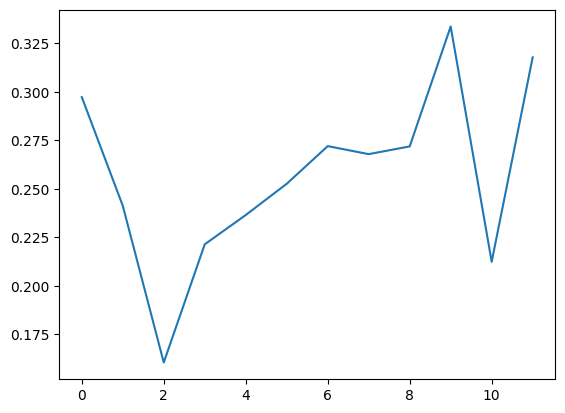

[PPO] Epoch 0: Loss=82.2215, Policy=0.0015, Value=164.5331
[PPO] Epoch 10: Loss=57.2499, Policy=-0.0062, Value=114.6032
[PPO] Epoch 20: Loss=46.0799, Policy=-0.0138, Value=92.2775
[PPO] Epoch 30: Loss=41.0723, Policy=-0.0195, Value=82.2725
Approx KL Learned: 0.021295875310897827
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 4/10 — steps: 4096


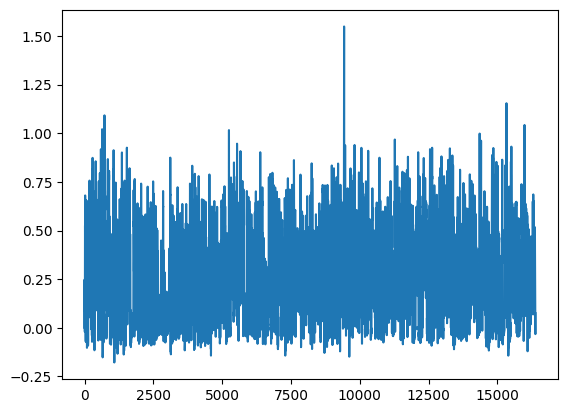

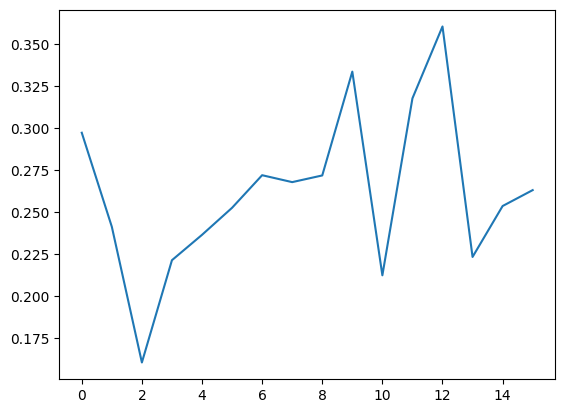

[PPO] Epoch 0: Loss=94.9972, Policy=0.0028, Value=190.0741
[PPO] Epoch 10: Loss=60.9737, Policy=-0.0072, Value=122.0457
[PPO] Epoch 20: Loss=54.5836, Policy=-0.0165, Value=109.2840
[PPO] Epoch 30: Loss=46.3755, Policy=-0.0269, Value=92.8879
Approx KL Learned: 0.028103362768888474
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 5/10 — steps: 4096


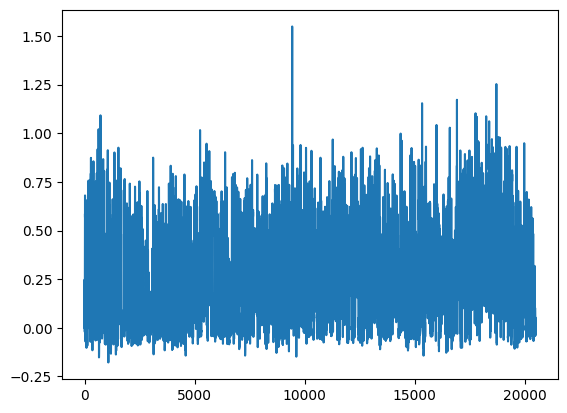

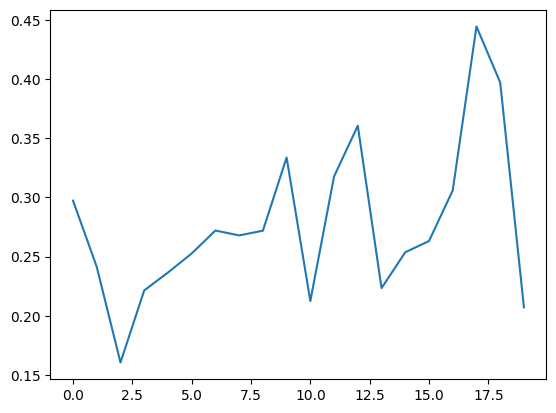

[PPO] Epoch 0: Loss=69.2200, Policy=0.0074, Value=138.5050
[PPO] Epoch 10: Loss=53.3258, Policy=-0.0017, Value=106.7342
[PPO] Epoch 20: Loss=43.4664, Policy=-0.0117, Value=87.0360
[PPO] Epoch 30: Loss=36.3761, Policy=-0.0217, Value=72.8718
Approx KL Learned: 0.1362391710281372
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 6/10 — steps: 4096


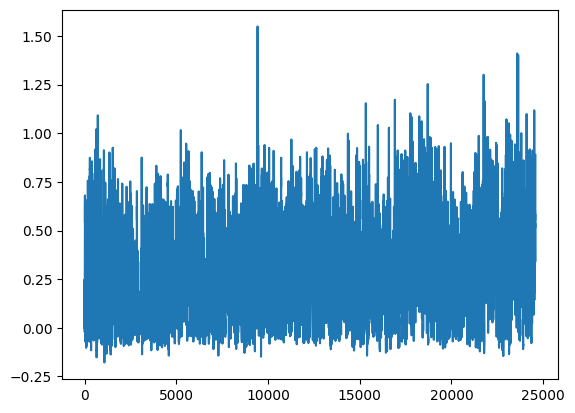

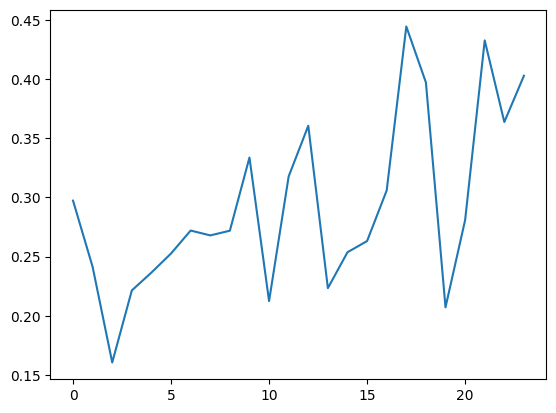

[PPO] Epoch 0: Loss=121.1008, Policy=0.0061, Value=242.2575
[PPO] Epoch 10: Loss=83.8504, Policy=0.0078, Value=167.7638
[PPO] Epoch 20: Loss=65.9298, Policy=-0.0034, Value=131.9419
[PPO] Epoch 30: Loss=59.1777, Policy=-0.0134, Value=118.4554
Approx KL Learned: 0.03578940033912659
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 7/10 — steps: 4096


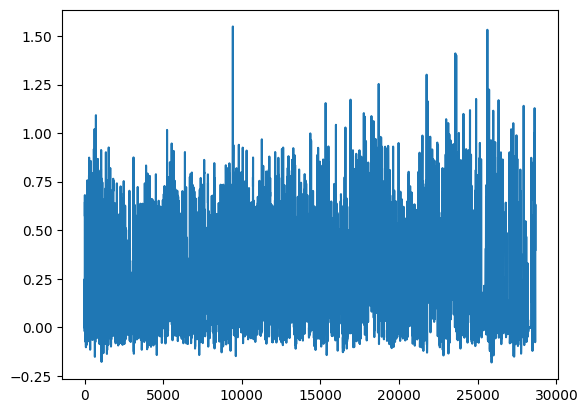

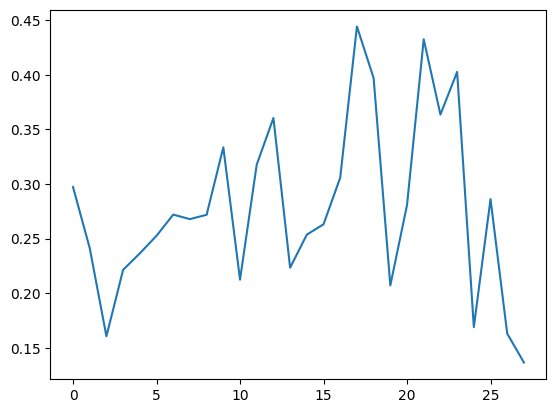

[PPO] Epoch 0: Loss=101.6436, Policy=0.0046, Value=203.3400
[PPO] Epoch 10: Loss=64.9889, Policy=-0.0048, Value=130.0569
[PPO] Epoch 20: Loss=43.8005, Policy=-0.0205, Value=87.7109
[PPO] Epoch 30: Loss=37.0609, Policy=-0.0302, Value=74.2536
Approx KL Learned: 0.1439504325389862
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 8/10 — steps: 4096


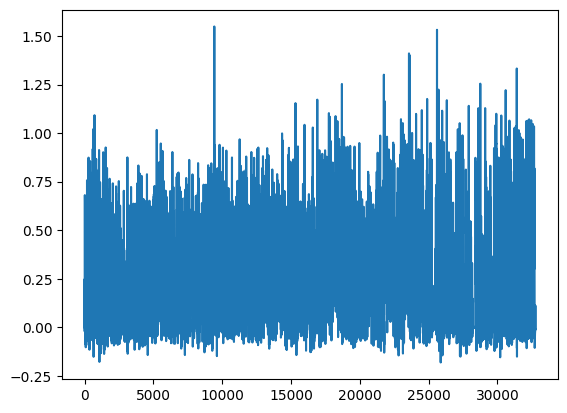

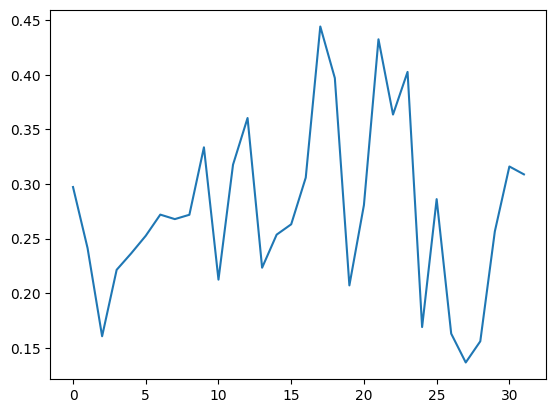

[PPO] Epoch 0: Loss=105.8971, Policy=0.0084, Value=211.8531
[PPO] Epoch 10: Loss=76.6015, Policy=0.0267, Value=153.2332
[PPO] Epoch 20: Loss=57.3876, Policy=-0.0036, Value=114.8617
[PPO] Epoch 30: Loss=46.5545, Policy=-0.0045, Value=93.1923
Approx KL Learned: 0.03431716188788414
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 9/10 — steps: 4096


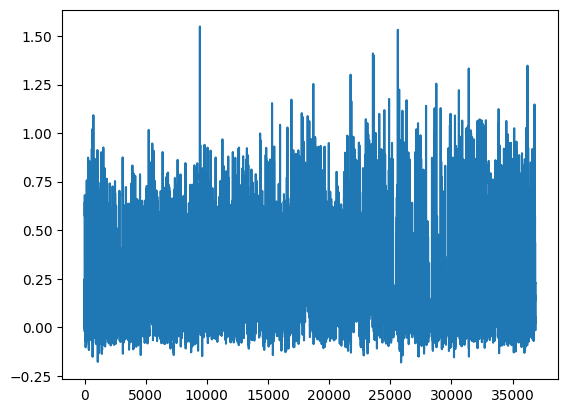

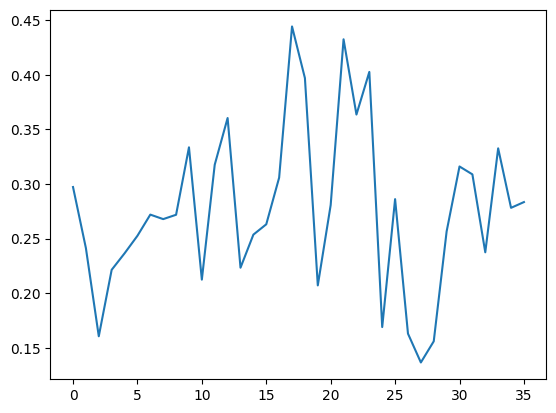

[PPO] Epoch 0: Loss=97.0014, Policy=0.0038, Value=194.0631
[PPO] Epoch 10: Loss=63.5704, Policy=-0.0050, Value=127.2187
[PPO] Epoch 20: Loss=44.6878, Policy=-0.0129, Value=89.4683
[PPO] Epoch 30: Loss=35.4802, Policy=-0.0222, Value=71.0732
Approx KL Learned: 0.025383828207850456
[✅] Actor-Critic checkpoint saved to clip_actor_critic_checkpoint_long_training_20_low_ent.pt
Update 10/10 — steps: 4096


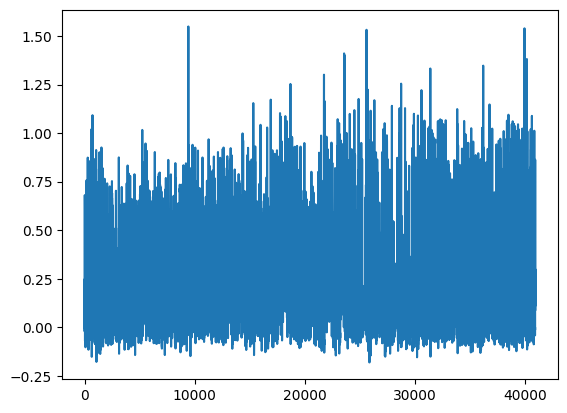

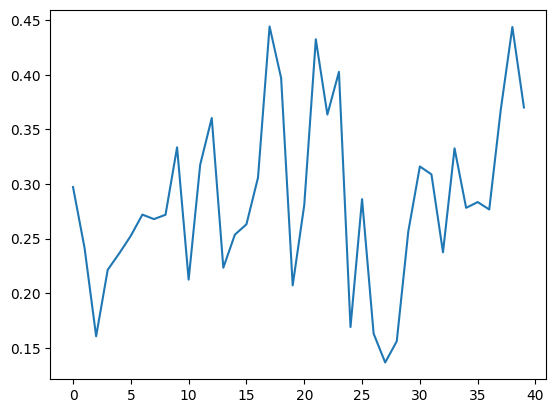

In [11]:
buf, rewards = train(controller, "clip_actor_critic_checkpoint_long_training_20_low_ent.pt", ppo, clip_env, clip_actor_critic, 10)

In [8]:
from rl import load_actor_critic

load_actor_critic(clip_actor_critic, "clip_actor_critic_checkpoint_long_training_10.pt")

[🔁] Actor-Critic checkpoint loaded from clip_actor_critic_checkpoint_long_training_10.pt


In [9]:
from cons import ACTIONS
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import imageio


def inference(get_distribution: Callable[[torch.Tensor, ActorCritic], torch.distributions.Categorical], init_position: dict[str, float], env: Env, actor_critic: ActorCritic, plot=True):
    n = 256
    n_row = 32
    positions = []

    plt.figure(figsize=(n // n_row * 2, n_row * 2))
    event = teleport(controller, init_position)
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)
    raw_obs = []
    for t in range(1, n + 1):
        positions.append([event.metadata["agent"]["position"]["x"], event.metadata["agent"]["position"]["z"]])
        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  # (C,H,W)
            obs_t_encoded = actor_critic.actor_critic_encoder(obs_t.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
            obs_seq = torch.stack(list(episode_seq) + [obs_t_encoded], dim=0).unsqueeze(0).to(device=DEVICE)

        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, (1, 1)).item())
        
        actions_tensor = torch.tensor(actions_seq, dtype=torch.long, device=DEVICE).unsqueeze(0)
        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample()
        logp = dist.log_prob(action_idx)
        
        action_idx, logp = action_idx.item(), logp.item()
        event, reward = env.step_env(controller, action_idx)

        # store one step
        episode_seq.append(obs_t_encoded)
        actions_seq.append(action_idx)
        raw_obs.append(obs_t)
        
        if plot:
            # Plot frame and action
            plt.subplot(n_row, n // n_row, t)
            plt.title("action: " + ACTIONS[action_idx] + ", r: " + f"{reward:.2f}" + "\n, prob = " + f"{torch.exp(dist.log_prob(torch.tensor([0, 1, 2], device=DEVICE))).cpu().numpy()}", fontsize=5)
            plt.axis(False)
            plt.imshow(event.frame)
    if plot:
        plt.tight_layout()
        plt.show()
        
        # ---- Plot 2D trajectory of the agent ----
        positions = np.array(positions)
        plt.figure(figsize=(4, 4))
        plt.plot(positions[:, 0], positions[:, 1], "-o", markersize=3)
        plt.xlabel("x")
        plt.ylabel("z")
        plt.title("Agent trajectory over n steps")
        plt.grid(True)
        plt.show()

    return raw_obs

def inference_video_mp4(
    get_distribution,
    init_position: dict[str, float],
    env: Env,
    actor_critic: ActorCritic,
    video_path="rollout.mp4",
    fps=10,
    n_steps=512
):
    episode_seq = deque(maxlen=EPISODE_STEPS)
    actions_seq = deque(maxlen=EPISODE_STEPS)

    writer = imageio.get_writer(video_path, fps=fps)

    # start episode
    event = teleport(controller, init_position)
    positions = []

    for t in range(1, n_steps + 1):

        # ---- Add current frame to video ----
        writer.append_data(event.frame[:, :, ::-1])   # convert RGB→BGR if needed

        # track positions
        positions.append([
            event.metadata["agent"]["position"]["x"],
            event.metadata["agent"]["position"]["z"],
        ])

        with torch.no_grad():
            obs_t = ppo.obs_from_event(event)  
            obs_enc = actor_critic.actor_critic_encoder(
                obs_t.unsqueeze(0).unsqueeze(0)
            ).squeeze(0).squeeze(0)

            obs_seq = torch.stack(
                list(episode_seq) + [obs_enc], dim=0
            ).unsqueeze(0).to(DEVICE)

        # ---- Action ----
        if len(actions_seq) == 0:
            actions_seq.append(torch.randint(0, NUM_ACTIONS, ()).item())

        actions_tensor = torch.tensor(
            actions_seq, dtype=torch.long, device=DEVICE
        ).unsqueeze(0)

        dist = get_distribution(obs_seq, actions_tensor, actor_critic)
        action_idx = dist.sample().item()

        # ---- Step env ----
        event, reward = env.step_env(controller, action_idx)

        # ---- Store ----
        episode_seq.append(obs_enc)
        actions_seq.append(action_idx)

    writer.close()
    print(f"[🎞️] Saved video to {video_path}")

    return positions


def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
    logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
    dist = torch.distributions.Categorical(logits=logits)
    return dist

event = teleport(controller)
init_pos = event.metadata["agent"]["position"]
inference_video_mp4(get_distributions, init_pos, clip_env, clip_actor_critic)

[🎞️] Saved video to rollout.mp4


[[10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.5, 1.75],
 [10.625, 1.5334936380386353],
 [10.625, 1.5334936380386353],
 [10.841506004333496, 1.4084936380386353],
 [11.058012008666992, 1.2834936380386353],
 [11.274518013000488, 1.1584936380386353],
 [11.491024017333984, 1.0334936380386353],
 [11.70753002166748, 0.9084936380386353],
 [11.70753002166748, 0.9084936380386353],
 [11.95753002166748, 0.9084936380386353],
 [12.20753002166748, 0.9084936380386353],
 [12.20753002166748, 0.9084936380386353],
 [12.20753002166748, 0.9084936380386353],
 [12.45753002166748

In [34]:
!pip install imageio imageio-ffmpeg

In [9]:
import clip

model, preprocess = clip.load("ViT-B/32", device=DEVICE)

In [10]:
import torch
import torch.nn.functional as F
import random

def preprocess_clip(x):
    # Resize to CLIP resolution
    x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
    # Normalize (CLIP standard mean/std)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=x.device).view(1, 3, 1, 1)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std

def get_average(input_img):
    # ---- 1. Sample 50 random images ----
    n = min(50, len(input_img))
    indices = random.sample(range(len(input_img)), n)
    imgs = torch.stack([input_img[i] for i in indices]).to(DEVICE)  # (50, 3, H, W)

    # ---- 2. Preprocess for CLIP ----
    imgs_clip = preprocess_clip(imgs).half()  # normalized, resized

    # ---- 3. Encode with CLIP visual encoder ----
    with torch.no_grad():
        embeds = model.visual(imgs_clip)       # (50, D)
        embeds = embeds / embeds.norm(dim=-1, keepdim=True)  # normalize to unit sphere

    # ---- 4. Compute cosine similarity ----
    sim_matrix = embeds @ embeds.T             # (50, 50)
    # Optional: remove self-similarity (diagonal = 1)
    sim_matrix.fill_diagonal_(0)

    # ---- 5. Summary statistics ----
    mean_sim = sim_matrix.mean().item()

    return mean_sim

for i in range(5):

    event = teleport(controller)
    init_pos = event.metadata["agent"]["position"]
    
    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        logits, value = ppo.act_and_value(obs_seq, actions_tensor, clip_actor_critic)
        dist = torch.distributions.Categorical(logits=logits)
        return dist

    policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    def get_distributions(obs_seq, actions_tensor, clip_actor_critic):
        dist = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.25, 0.25], device=DEVICE))
        return dist

    rand_policy = inference(get_distributions, init_pos, clip_env, clip_actor_critic, False)

    mean_policies = []
    mean_rands = []
    for i in range(10):
        mean_policy = get_average(policy)
        mean_rand = get_average(rand_policy)
        mean_policies.append(mean_policy)
        mean_rands.append(mean_rand)
    
    print("Policy: " + str(np.mean(np.array(mean_policies))))
    print("Rand: " + str(np.mean(np.array(mean_rands))))



Policy: 0.84921875
Rand: 0.790966796875
Policy: 0.867724609375
Rand: 0.836279296875
Policy: 0.835107421875
Rand: 0.752294921875
Policy: 0.83193359375
Rand: 0.7958984375
Policy: 0.868505859375
Rand: 0.871484375


<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

<Figure size 1600x6400 with 0 Axes>

In [20]:
controller.stop()